In [1]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune

from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.algorithms.rl import EnergyCommunityMultiEnv_v0

2023-10-16 14:47:43,210	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define resources

resources = []

# Add the generators
for i in range(data.generator['p_forecast'].shape[0]):
    resources.append(Generator(name='gen_{:02d}'.format(i+1),
                               value=np.zeros(data.generator['p_forecast'][0].shape),
                               lower_bound=np.zeros(data.generator['p_forecast'].shape),
                               upper_bound=data.generator['p_forecast'][i],
                               cost=data.generator['cost_parameter_b'][i],
                               cost_nde=data.generator['cost_nde'][i],
                               is_renewable=data.generator['type_generator'][i]))

# Add the loads
for i in range(data.load['p_forecast'].shape[0]):
    resources.append(Load(name='load_{:02d}'.format(i+1),
                          value=data.load['p_forecast'][i],
                          lower_bound=np.zeros(data.load['p_forecast'][i].shape),
                          upper_bound=data.load['p_forecast'][i],
                          cost=np.ones(data.load['p_forecast'][i].shape),
                          cost_cut=data.load['cost_cut'][i],
                          cost_reduce=data.load['cost_reduce'][i],
                          cost_ens=data.load['cost_ens'][i]))

In [4]:
# Create the environment and check if everything is ok

temp_env = EnergyCommunityMultiEnv_v0(resources=resources)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    # print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [5]:
temp_env.load_consumption

OrderedDict([('load_01',
              array([5.525, 5.119, 4.8116, 4.7104, 4.7018, 4.7526, 4.943, 5.2756,
                     5.7108, 6.4174, 6.934, 7.2706, 7.222, 6.9262, 6.7334, 6.4846,
                     6.4248, 6.8866, 7.1332, 7.1374, 6.9804, 6.603, 6.1236, 5.6578],
                    dtype=object)),
             ('load_02',
              array([0.8080844, 0.755402, 0.7249986, 0.7193732, 0.7363022, 0.7761784,
                     0.894726, 1.1540718, 1.530171, 1.7752608, 1.8483228, 1.890054,
                     1.727325, 1.7075894, 1.7512282, 1.7023568, 1.6733952, 1.6397032,
                     1.5239016, 1.383727, 1.2719956, 1.1641036, 1.0554584, 0.9164624],
                    dtype=object)),
             ('load_03',
              array([1.077446, 1.0072026, 0.9666648, 0.9591642, 0.9817362, 1.0349046,
                     1.192968, 1.5387624, 2.040228, 2.3670144, 2.4644304, 2.520072,
                     2.3031, 2.2767858, 2.3349708, 2.269809, 2.2311936, 2.186271,
        

In [6]:
# Aux function to assign policies

def assign_policies(env):

    policies = {}
    for agent in env.agents:
        policies[agent] = (None,
                           env.observation_space[agent],
                           env.action_space[agent],
                           {})
    return policies

policies = assign_policies(env=temp_env)

In [7]:
from ray.tune import register_env

# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

ray.shutdown()
ray.init()

register_env("EC_Multi", lambda config: EnergyCommunityMultiEnv_v0(resources=resources))

config = (
    PPOConfig()
    .environment(env="EC_Multi")
    .training(
        train_batch_size=240,
        lr=2e-4,
        gamma=0.99)
        # entropy_coeff=0.05,
        # kl_coeff=0.0)
    .framework('torch')# 'tf2', eager_tracing=False)
    .rollouts(num_rollout_workers=10, rollout_fragment_length=24)
    .multi_agent(policies=policies,
                 policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: agent_id)
)
# Use the config's `build()` method to construct a PPO object.
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
# Since we have to guess 10 times and the optimal reward is 0.0
# (exact match between observation and action value),
# we can expect to reach an optimal episode reward of 0.0.
checkpoint = None
for i in range(20):
    results = algo.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    if results['episode_reward_mean'] > -50.0:
        break

    # Save the checkpoint to disk.
    checkpoint = algo.save()
    print("checkpoints saved at", checkpoint)

2023-10-16 14:47:57,619	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-16 14:48:00,712	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2023-10-16 14:48:00,732	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
C:\Users\camar\DataspellProjects\phd_thesis\pyeco

Iter: 0; avg. reward=nan
checkpoints saved at TrainingResult(checkpoint=Checkpoint(filesystem=local, path=C:\Users\camar\AppData\Local\Temp\tmp6ao3_ffi), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'__all__': {'num_agent_steps_trained': 1920.0, 'num_env_steps_trained': 240.0, 'total_loss': 24.3271897968493}, 'gen_01': {'total_loss': 24.3271897968493, 'policy_loss': -0.0613783705129958, 'vf_loss': 0.5494002600510915, 'vf_loss_unclipped': 0.5494002600510915, 'vf_explained_var': 0.43228456221128764, 'entropy': 0.6449655953206515, 'mean_kl_loss': 0.022878946566105226, 'default_optimizer_lr': 0.00020000000000000004, 'curr_lr': 0.0002, 'curr_entropy_coeff': 0.0, 'curr_kl_coeff': 0.30000001192092896}, 'gen_02': {'total_loss': 8.147838843496222, 'policy_loss': -0.06881173177246462, 'vf_loss': 8.210338207713345, 'vf_loss_unclipped': 141.3097093147144, 'vf_explained_var': 0.017050836169928835, 'entropy': 0.6525198879994845, 'mean_kl_loss': 0.03156231973149479, 'defau

In [7]:
algo.evaluation_metrics

{'evaluation': {'episode_reward_max': nan,
  'episode_reward_min': nan,
  'episode_reward_mean': nan}}

In [8]:
algo.get_state()

{'experiment_id': 'f17ca703c9c5469c8955614227916776',
 'iteration': 51,
 'timesteps_total': None,
 'time_total': 319.8085913658142,
 'episodes_total': 480,
 'last_result': {'custom_metrics': {},
  'episode_media': {},
  'info': {'learner': {'ev_01': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 3.35230633020401,
      'cur_kl_coeff': 1.0125000000000004,
      'cur_lr': 0.00020000000000000006,
      'total_loss': 0.5525870109597842,
      'policy_loss': -0.044166264380328356,
      'vf_loss': 0.5844656830032666,
      'vf_explained_var': 0.6799756834904352,
      'kl': 0.01213589980325196,
      'entropy': 2.4159503102302553,
      'entropy_coeff': 0.0},
     'model': {},
     'custom_metrics': {},
     'num_agent_steps_trained': 120.0,
     'num_grad_updates_lifetime': 3030.5,
     'diff_num_grad_updates_vs_sampler_policy': 29.5},
    'storage_03': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 3.1806362678607303,
      'cur_kl_coeff': 0.75937500000

In [9]:
# Check the actions (inference)

temp_env = EnergyCommunityMultiEnv_v0()
obs, info = temp_env.reset()
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
episode_info = []
while not terminations['__all__'] and not truncations['__all__']:
    print('Timestep: {}'.format(temp_env.current_timestep))
    action_dict = {a: algo.compute_single_action(observation=obs[a], policy_id=a) for a in temp_env.agents}
    #action_dict = {'producer': algo.compute_single_action(observation=obs['producer'], policy_id='pol_producer'),
    #               'consumer': algo.compute_single_action(observation=obs['consumer'], policy_id='pol_consumer')}
    obs, reward, terminations, truncations, info = temp_env.step(action_dict)
    episode_info.append(info)
    #total_reward_prod += reward['producer']
    #total_reward_cons += reward['consumer']
    #print(f"Producer Action: {action_dict['producer']}; reward: {reward['producer']}; total reward: {total_reward_prod}")
    #print(f"Consumer Action: {action_dict['consumer']}; reward: {reward['consumer']}; total reward: {total_reward_cons}")

Timestep: 0
Timestep: 1
Timestep: 2
Timestep: 3
Timestep: 4
Timestep: 5
Timestep: 6
Timestep: 7
Timestep: 8
Timestep: 9
Timestep: 10
Timestep: 11
Timestep: 12
Timestep: 13
Timestep: 14
Timestep: 15
Timestep: 16
Timestep: 17
Timestep: 18
Timestep: 19
Timestep: 20
Timestep: 21
Timestep: 22
Timestep: 23
Timestep: 24


In [10]:
episode_info

[{'gen_01': {'production': 0.0, 'reward': -0.07015490666666667},
  'gen_02': {'production': 0.0, 'reward': -0.07015490666666667},
  'gen_03': {'production': 0.0, 'reward': -0.07015490666666667},
  'gen_04': {'production': 0.0, 'reward': -0.07015490666666667},
  'gen_05': {'production': 0.0, 'reward': -0.07015490666666667},
  'gen_06': {'production': 18.0, 'reward': -1.5101549066666666},
  'gen_07': {'production': 0.0, 'reward': -0.07015490666666667},
  'storage_01': {'current': 8.0,
   'charge': 0.0,
   'discharge': 0.0,
   'reward': -0.07015490666666667},
  'storage_02': {'current': 0.0,
   'charge': 0.0,
   'discharge': 16.0,
   'reward': -1.3501549066666667},
  'storage_03': {'current': 3.2,
   'charge': 0.0,
   'discharge': 0.0,
   'reward': -0.07015490666666667},
  'ev_01': {'current': 20.0,
   'charge': 0.0,
   'discharge': 0.0,
   'reward': -0.07015490666666667},
  'ev_02': {'current': 30.0,
   'charge': 0.0,
   'discharge': 0.0,
   'reward': -0.07015490666666667},
  'ev_03': {'

[]

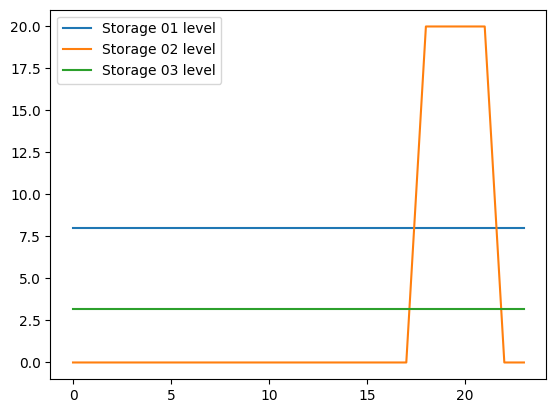

In [11]:
# Plot the storage

for s in range(1, 4):
    temp_storage = [episode_info[i]['storage_{:02d}'.format(s)]['current']
                    for i in range(len(episode_info) - 1)]
    plt.plot(temp_storage,
             label='Storage {:02d} level'.format(s))

plt.legend()
plt.plot()

[]

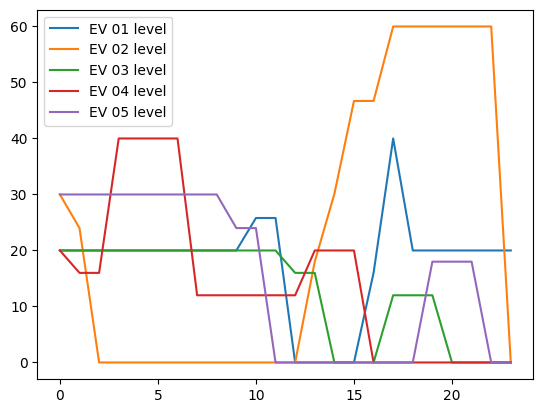

In [12]:
# Plot the EVs

for e in range(1, 6):
    temp_ev = [episode_info[i]['ev_{:02d}'.format(e)]['current']
               for i in range(len(episode_info) - 1)]
    plt.plot(temp_ev,
             label='EV {:02d} level'.format(e))

plt.legend()
plt.plot()

In [4]:
import torch

torch.device('cuda')

device(type='cuda')

In [5]:
torch.cuda.is_available()

False

In [6]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [1]:
import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.1.0+cu118
Is CUDA enabled? True
